# Weights & Biases (WandB)

## Install `wandb` library and login


First, please complete the sign-up process on the WandB website

https://wandb.ai/


In [2]:
!pip install wandb -qU

Afterward, please create a new project.

Once you create the project, your API key will be displayed. Please use this key when logging in the following cell

In [4]:
# Log in to your W&B account
import wandb
wandb.login()

True

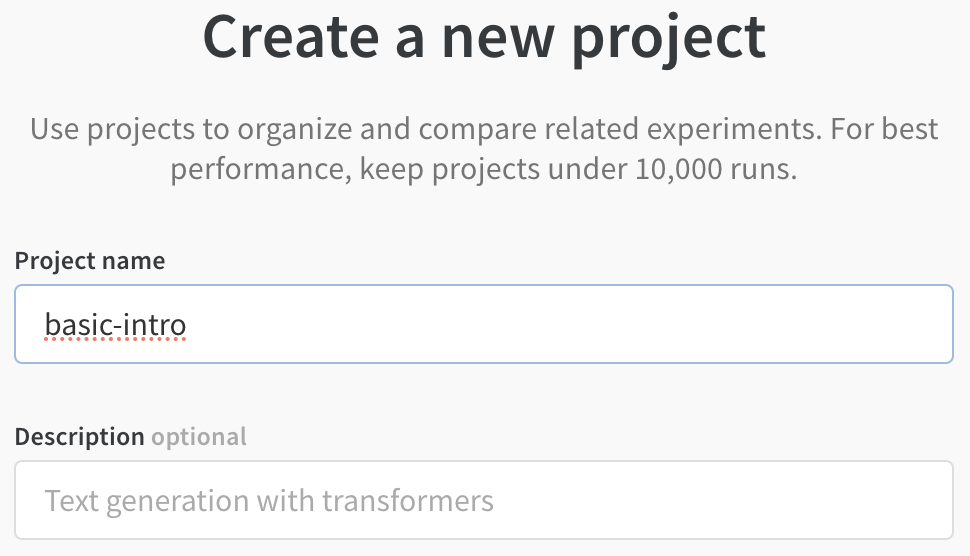

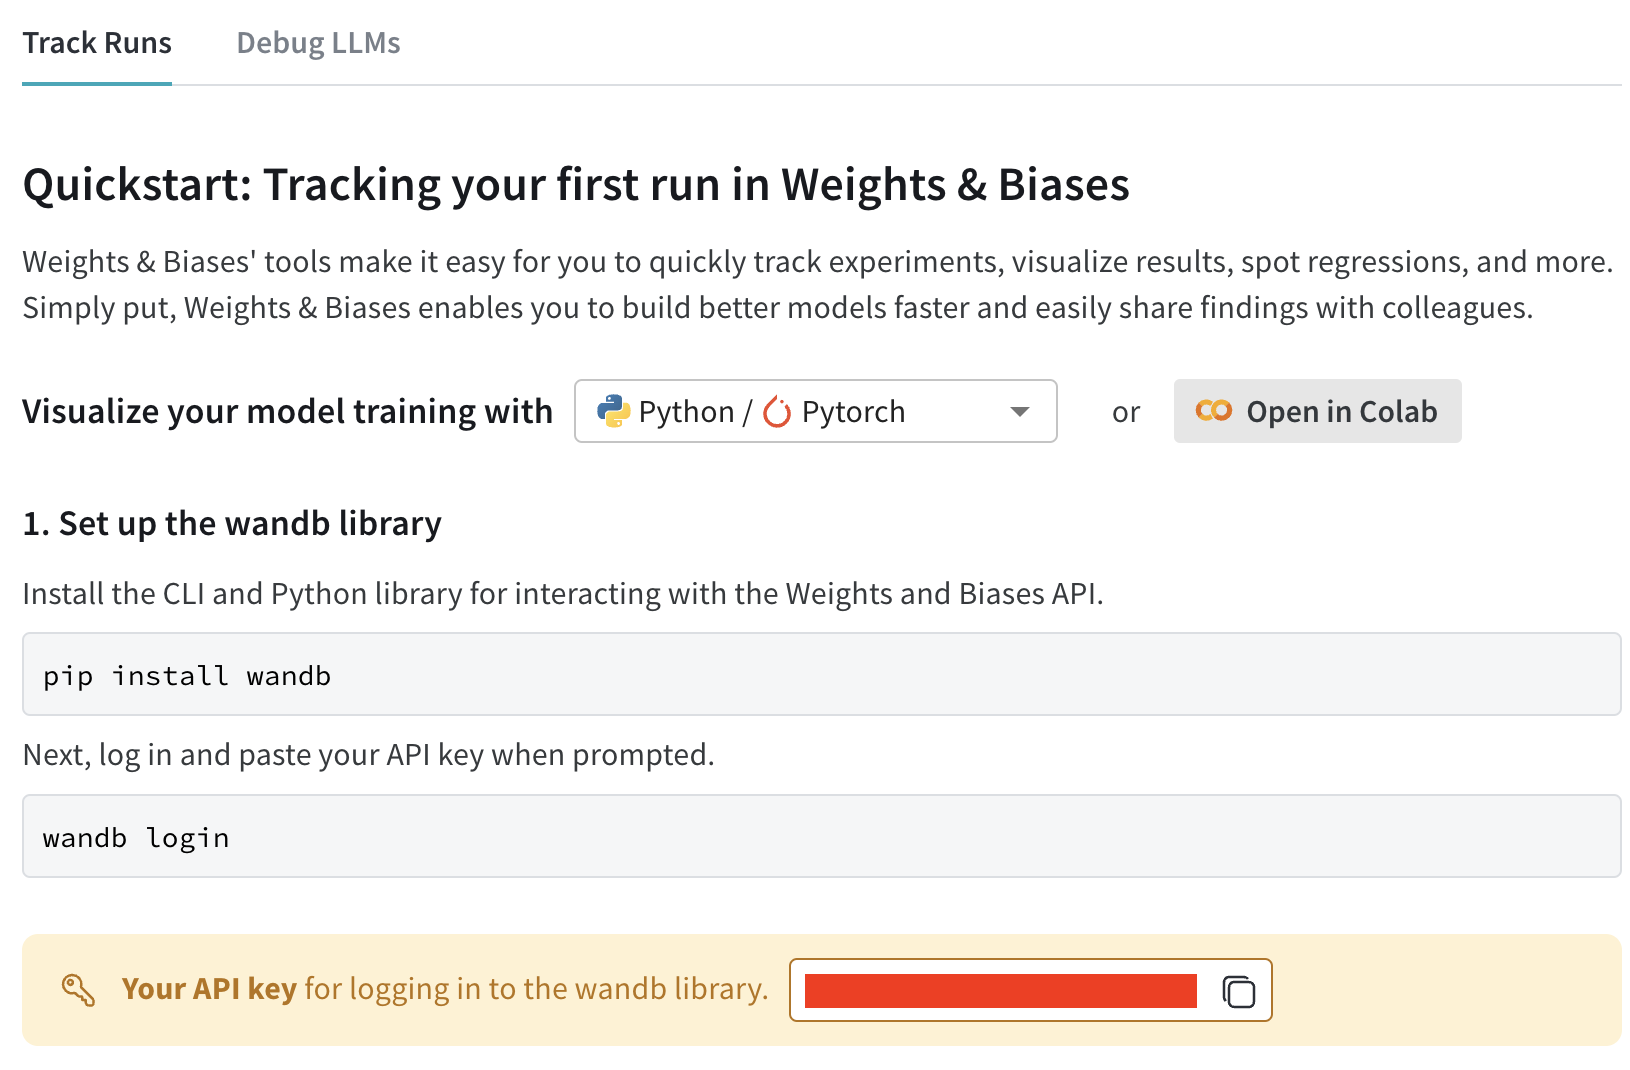

The part covered in red is your API key.


## Loss Plot & Visualization

We will use a modified version of the code we used in the previous practical session.
  - Instead of using the test set, We will use a portion of the train set as the validation set.
  - The model will be modified to have three linear layers.

In [5]:
# hyper-parameter
learning_rate = 1e-3
batch_size = 64
epochs = 5
hidden_dim = 512

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from torch.utils.data.dataset import random_split


device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using {device} device")

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# validation split
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=512, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.classifier(x)
        return x


Using mps device


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    train_acc /= size
    print(f"Train Error: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return train_loss, train_acc

def validation_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, validation_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            validation_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= num_batches
    validation_acc /= size
    print(f"Validation Error: \n Accuracy: {(100*validation_acc):>0.1f}%, Avg loss: {validation_loss:>8f} \n")

    return validation_loss, validation_acc

Let's now use the WandB logger more extensively.
1. First, initialize with `wandb.init()`:
  - project: Project name
  - name: Experiment name
  - config: Configurations to be saved in WandB
2. Log information using `wandb.log()`:
  - You can log desired data in dictionary format.
  - Various types of data, such as images, videos, audio, bounding boxes, segmentation maps, gradient histograms, etc., can be logged.
  - For more detailed information, refer to the official documentation (https://docs.wandb.ai/guides/track/log/media).

In [8]:
def run():
  wandb.init(
    # Set the project where this run will be logged
    project="basic-intro",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name="experiment",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs,
    "hidden_dim": hidden_dim,
    })

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
  validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

  model = NeuralNetwork(hidden_dim=hidden_dim).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  best_validation_acc = 0.0
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
      validation_loss, validation_acc = validation_loop(validation_dataloader, model, loss_fn)

      sample_batch, _ = next(iter(train_dataloader))
      sample_img = to_pil_image(sample_batch[0])
      sample_img = wandb.Image( # single image
        sample_img,
        caption="sample image"
        )

      images = [to_pil_image(image) for image in sample_batch[:5]] # multiple images

      wandb.log({
          "train_acc": train_acc,
          "train_loss": train_loss,
          "validation_acc": validation_acc,
          "validation_loss": validation_loss,
          "example": sample_img,
          "examples": [wandb.Image(image) for image in images],
          })

      if validation_acc > best_validation_acc:
        torch.save(model.state_dict(), './best.pth')

  print("Done!")
  wandb.finish()

In [9]:
run()

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 22.9%, Avg loss: 2.256751 

Validation Error: 
 Accuracy: 45.1%, Avg loss: 2.201889 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 51.6%, Avg loss: 2.130181 

Validation Error: 
 Accuracy: 58.4%, Avg loss: 2.038951 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 59.5%, Avg loss: 1.912010 

Validation Error: 
 Accuracy: 60.3%, Avg loss: 1.764460 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 60.3%, Avg loss: 1.615834 

Validation Error: 
 Accuracy: 61.9%, Avg loss: 1.472336 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 62.7%, Avg loss: 1.362888 

Validation Error: 
 Accuracy: 64.0%, Avg loss: 1.261993 

Done!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_acc,▁▆▇██
train_loss,█▇▅▃▁
validation_acc,▁▆▇▇█
validation_loss,█▇▅▃▁
train_acc,0.62731
train_loss,1.36289
validation_acc,0.6405
validation_loss,1.26199


After the execution, you can check the results as follows:
  - single image
  - multiple images
  - charts

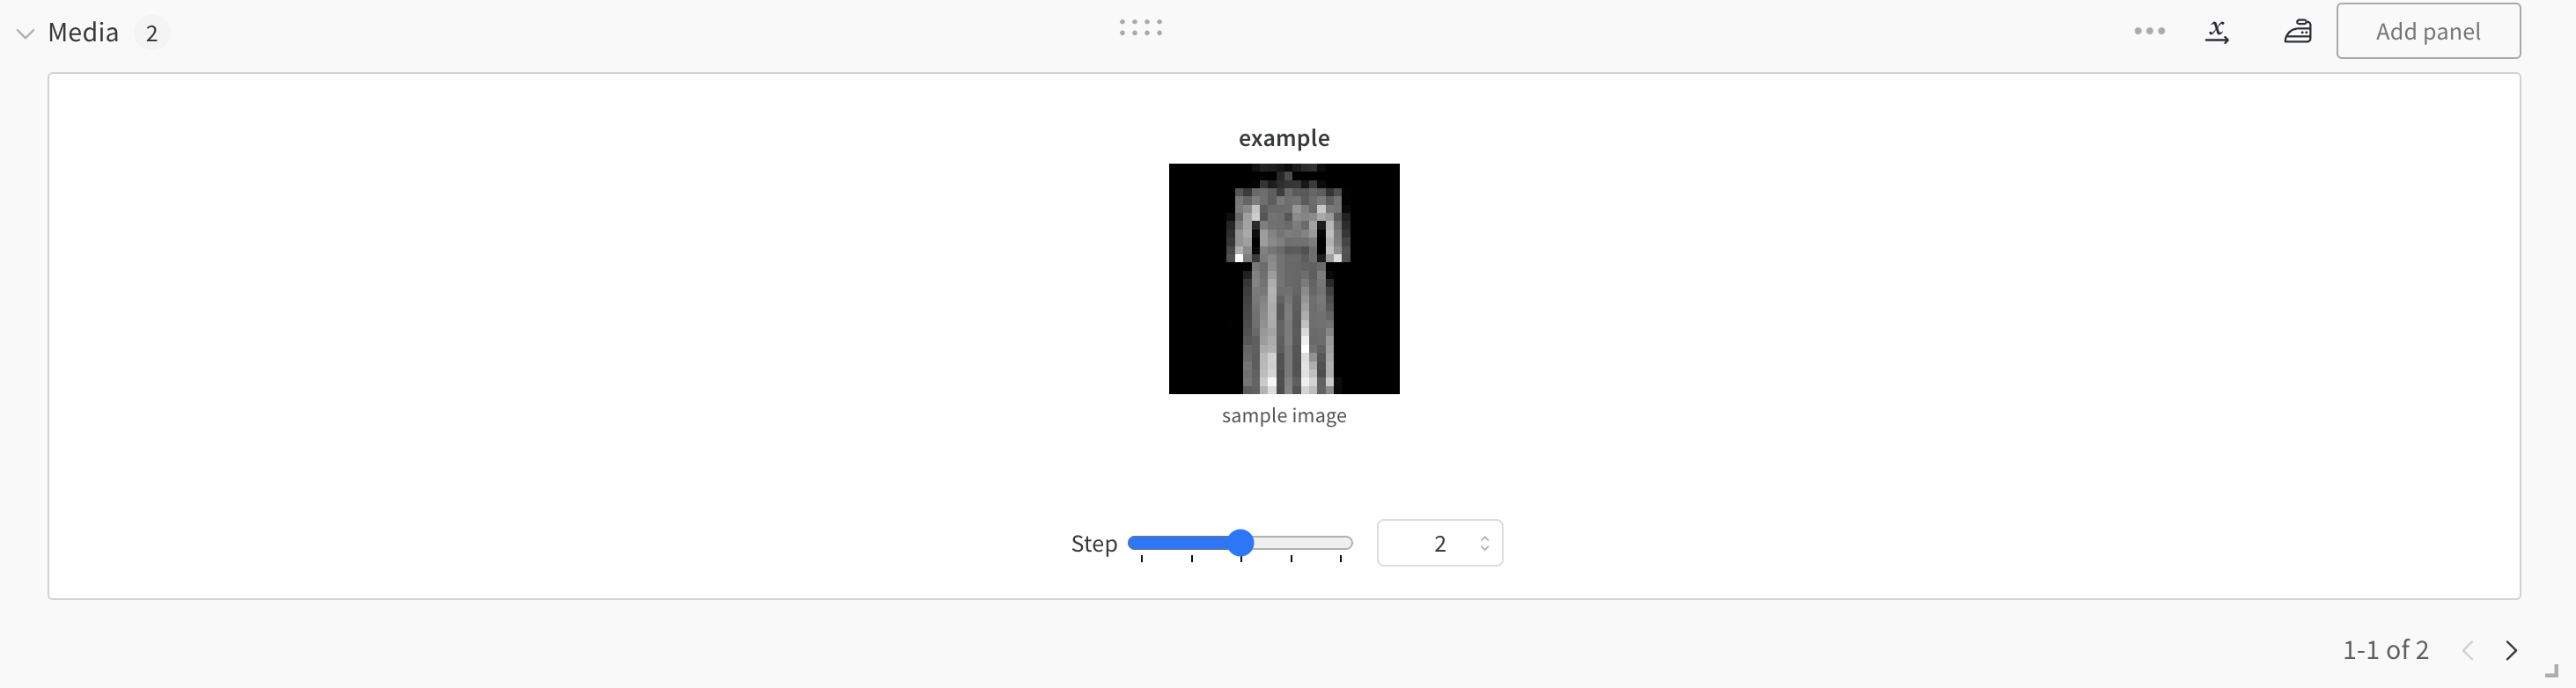

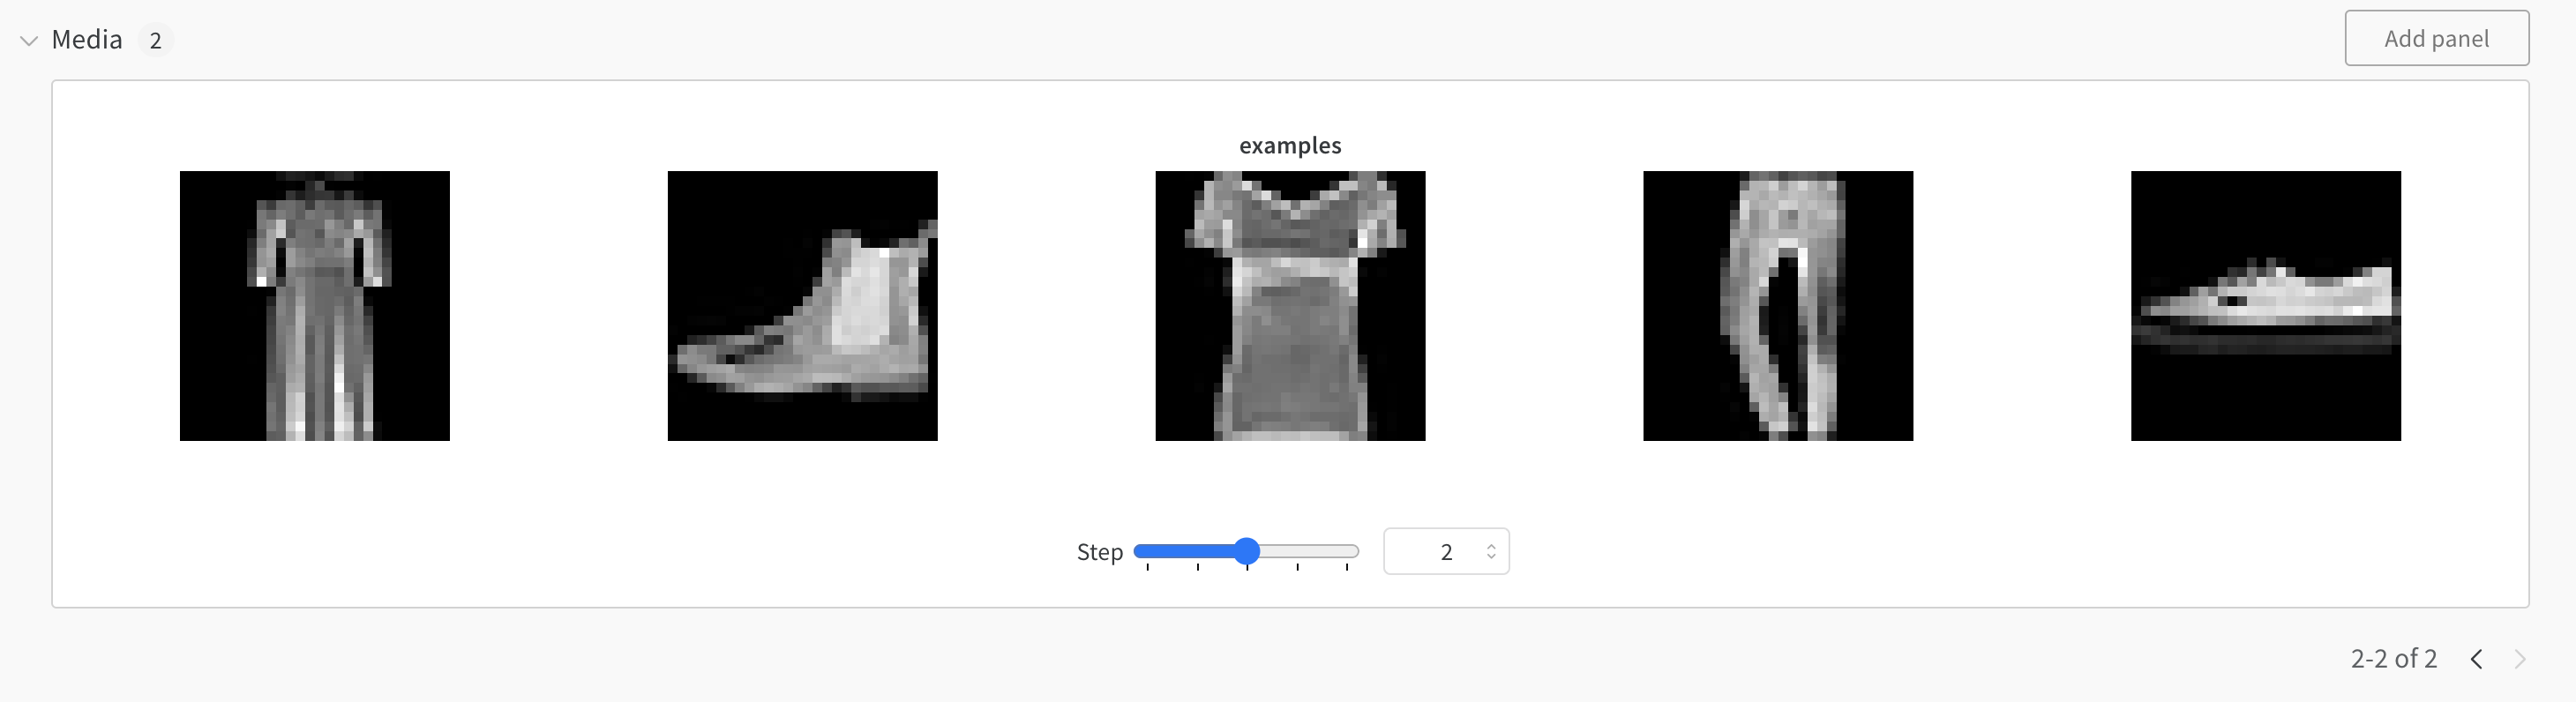

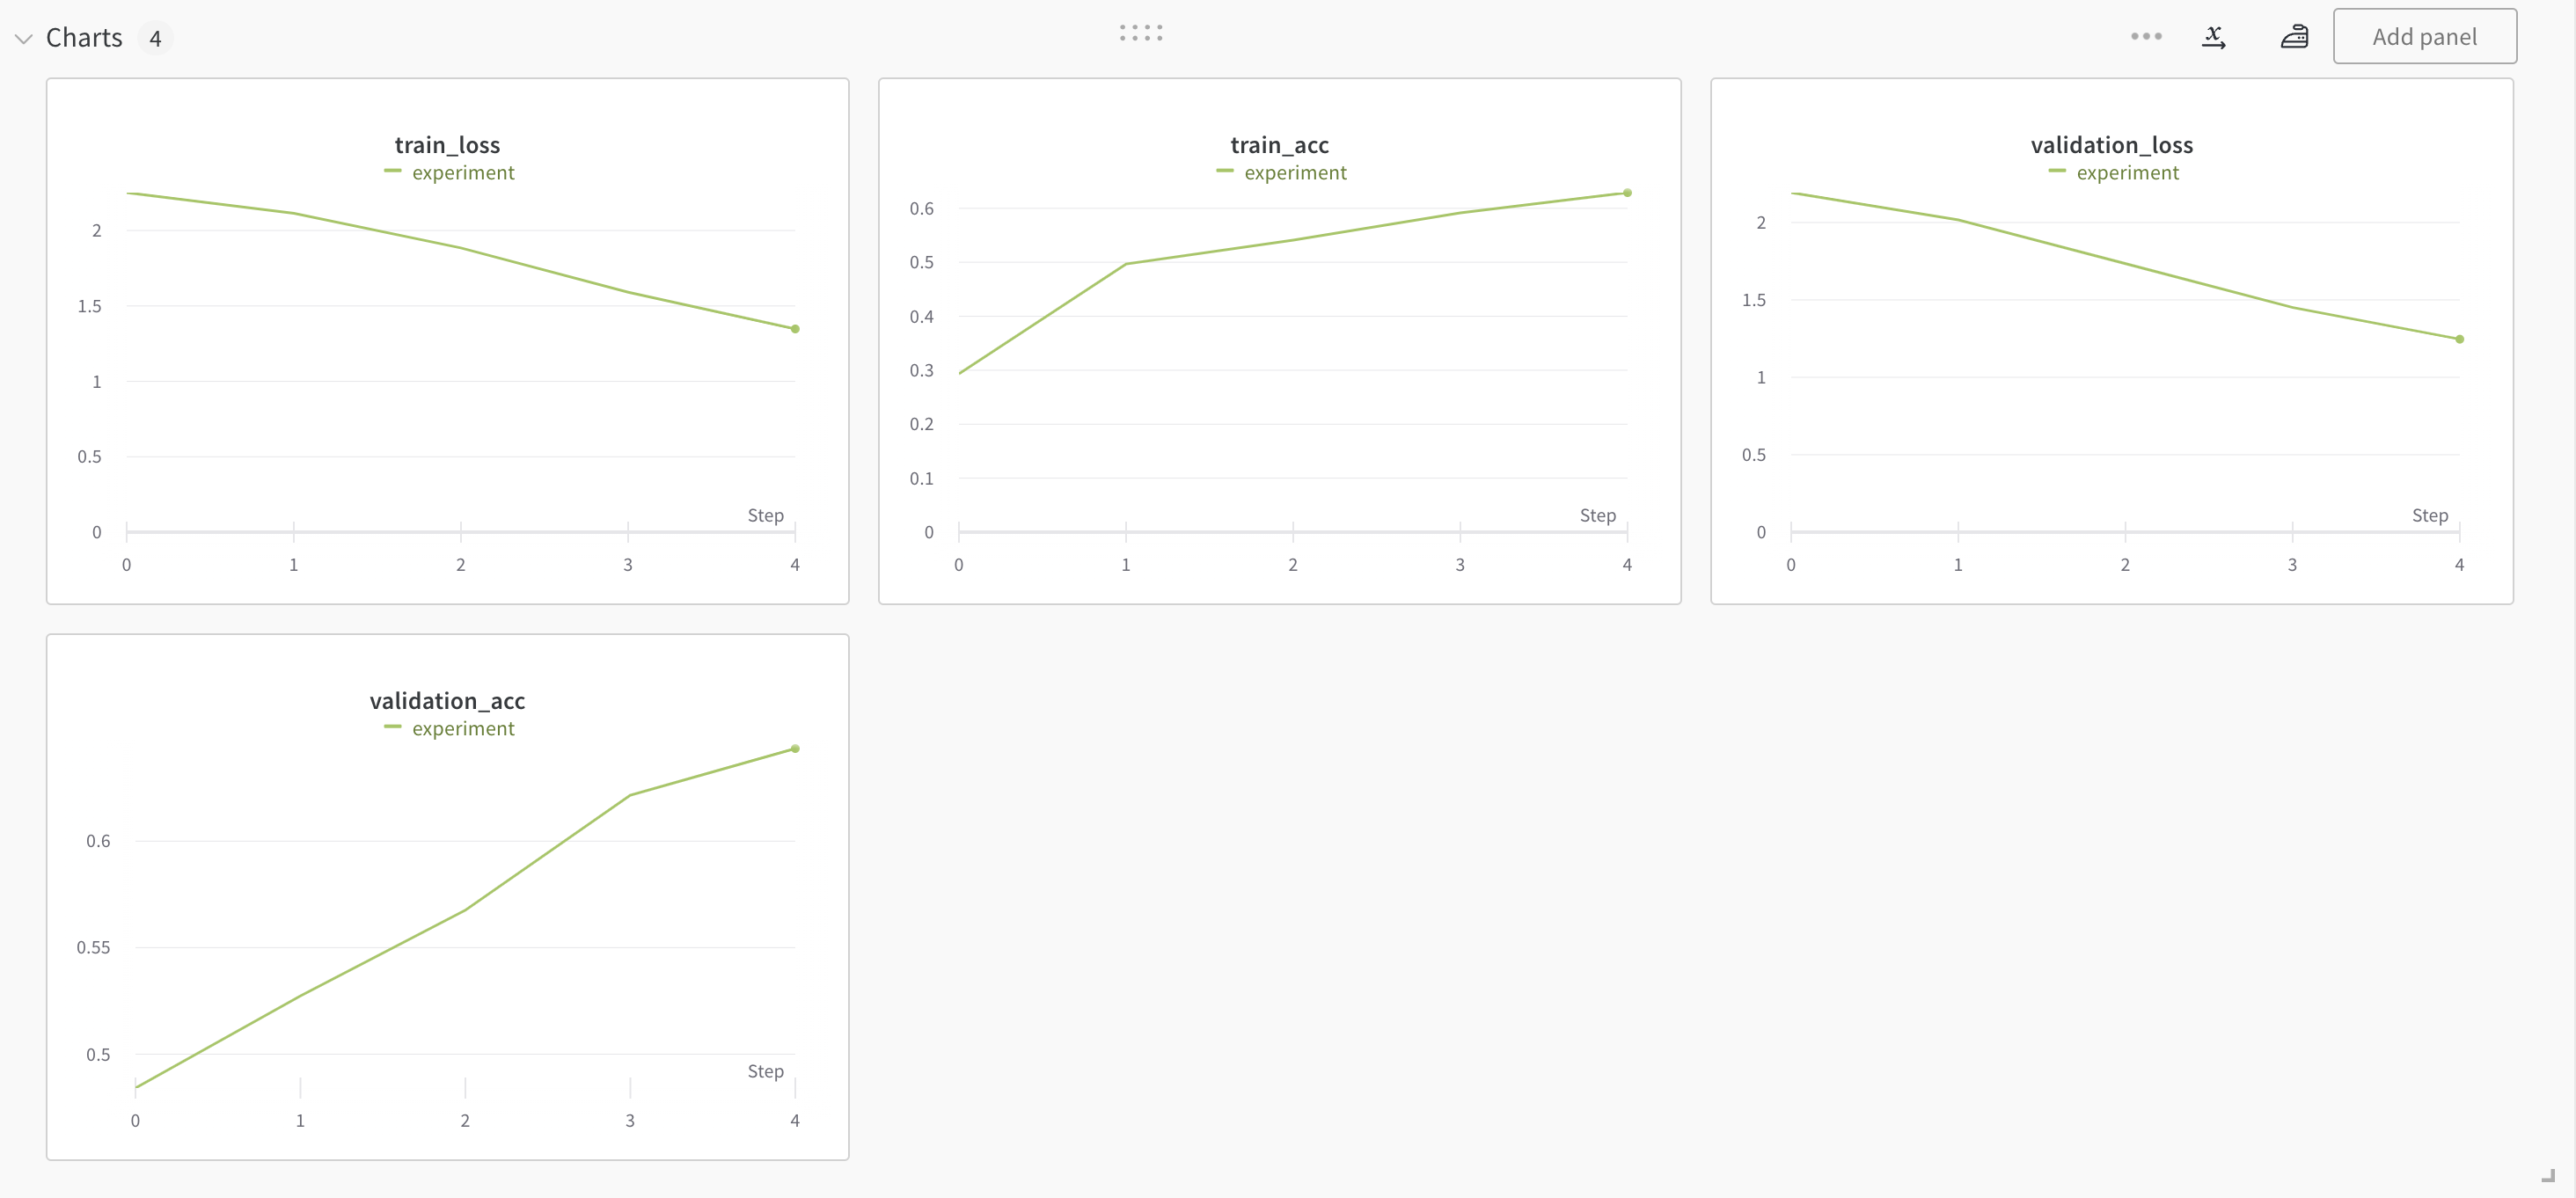

You can customize the appearance of each chart by adjusting options such as range and smoothing for better visualization.

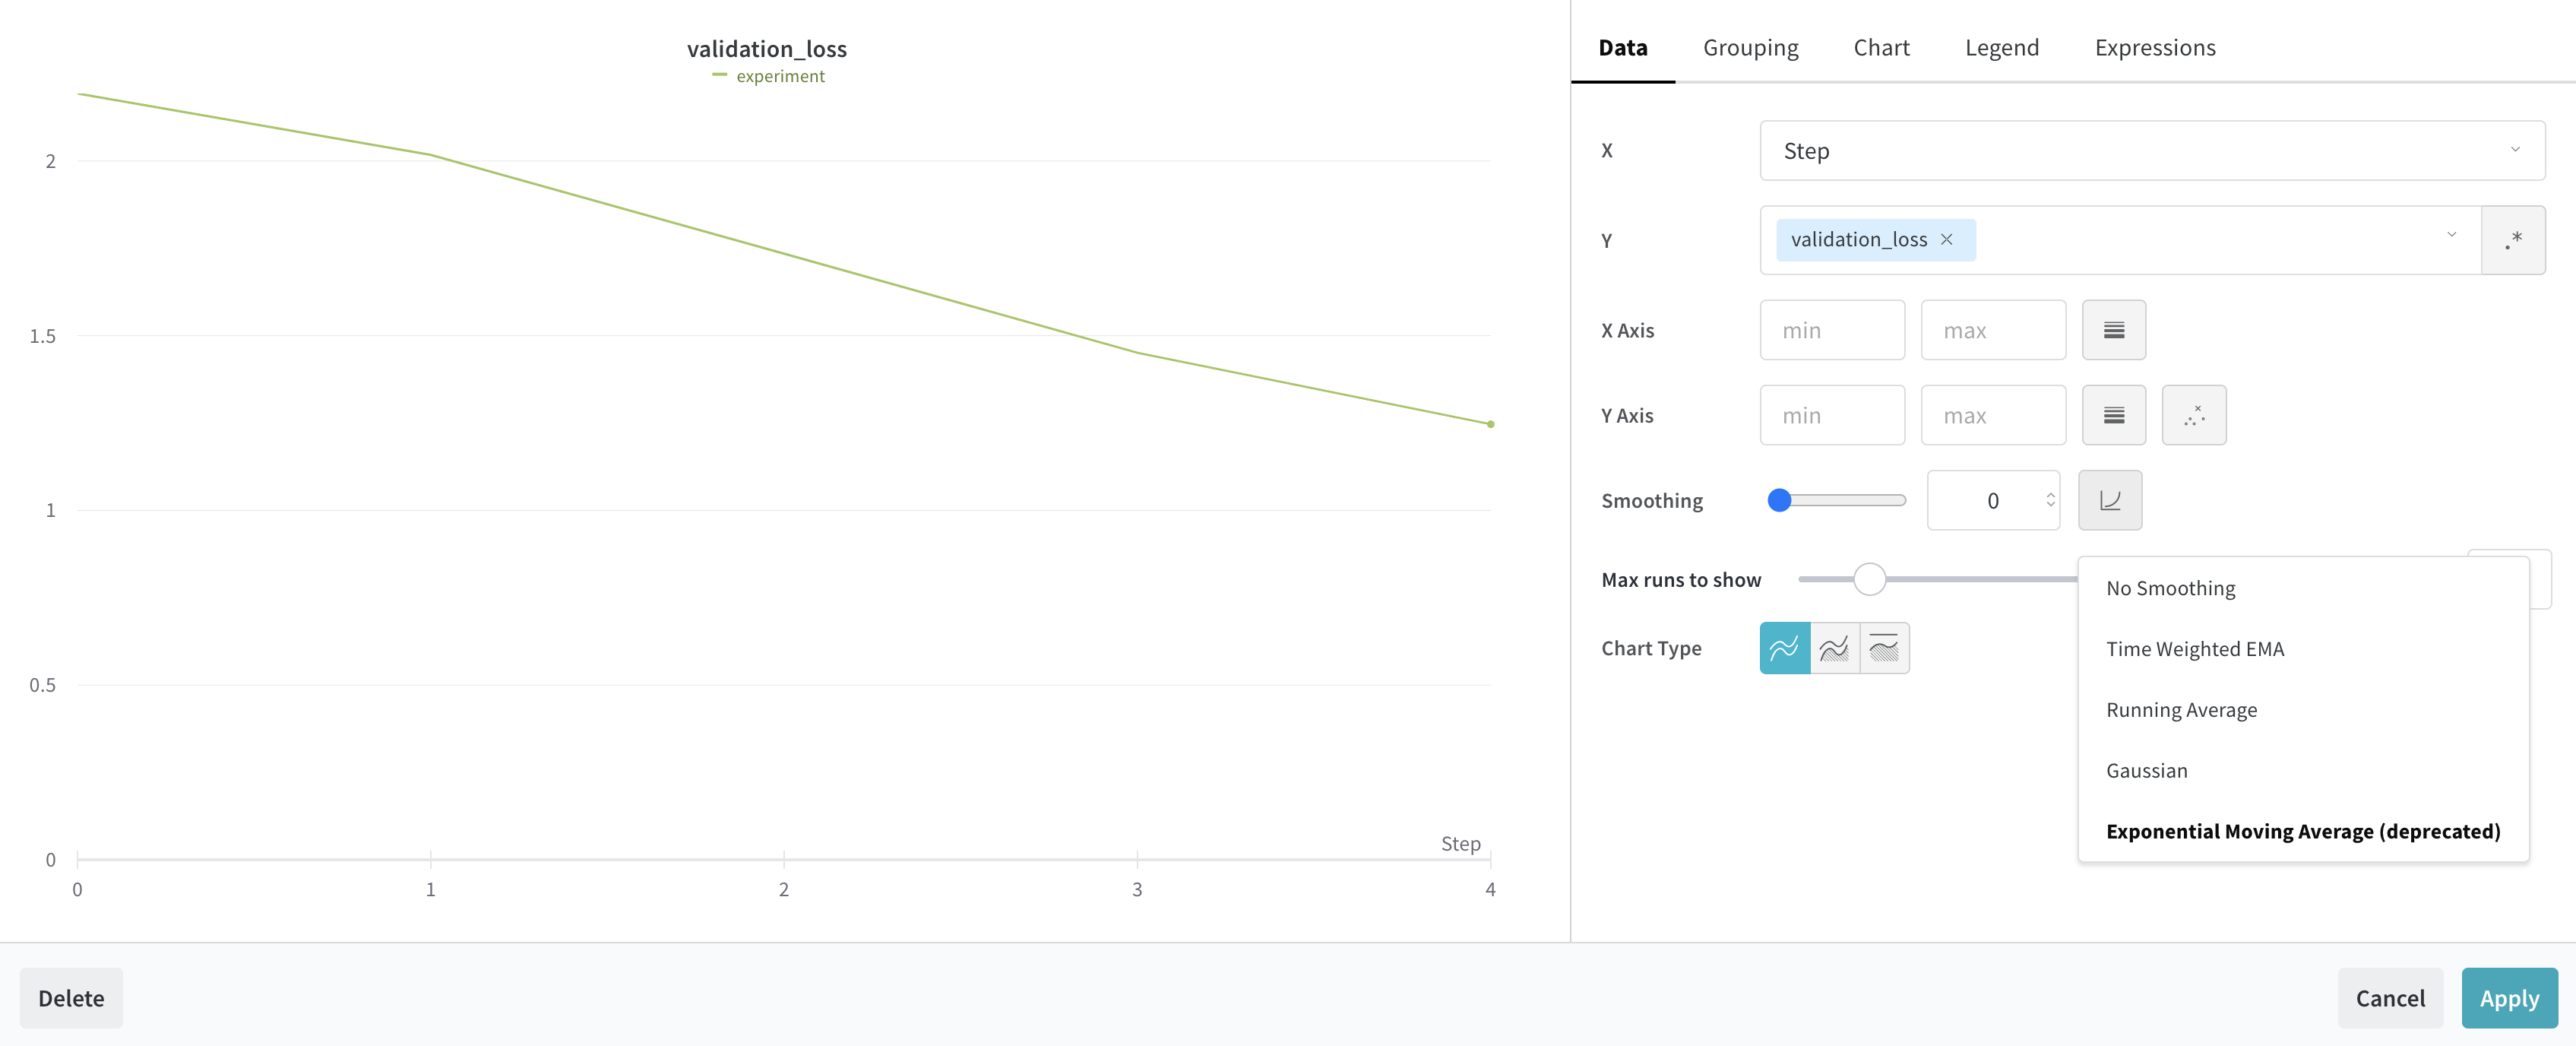

## Hyperparameter search(WandB Sweep)

WandB provides a hyperparameter tuning feature called Sweep.

First, let's make some modifications to the `run()` function to make it compatible with sweeps.
  - Modify the function to take the configuration as an input.
  - Also, let's change the hyperparameter values to be tuned in the form of `config['foo']`.
  - Specify the hyperparameters you want to tune and their ranges.


In [ ]:
def run_sweep(config=None):
  with wandb.init(config=config):
    config=wandb.config
    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'])
    validation_dataloader = DataLoader(validation_dataset, batch_size=config['batch_size'])

    model = NeuralNetwork(hidden_dim=config['hidden_dim']).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

    best_validation_acc = 0.0
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        validation_loss, validation_acc = validation_loop(validation_dataloader, model, loss_fn)

        sample_batch, _ = next(iter(train_dataloader))
        sample_img = to_pil_image(sample_batch[0])
        sample_img = wandb.Image(
          sample_img,
          caption="sample image"
          )

        images = [to_pil_image(image) for image in sample_batch[:5]]

        wandb.log({
            "train_acc": train_acc,
            "train_loss": train_loss,
            "validation_acc": validation_acc,
            "validation_loss": validation_loss,
            "example": sample_img,
            "examples": [wandb.Image(image) for image in images],
            })

        if validation_acc > best_validation_acc:
          torch.save(model.state_dict(), './best.pth')
    print("Done!")

Specify the hyperparameters to be tuned and their ranges.

Here, we will use random search for tuning.
  - `name`:
    - Name of the metric to optimize.
    - The `name` of the `metric` should be one of the key values used in `wandb.log()`.
  - `goal`:
    - Either `minimize` or `maximize` (Default is `minimize`).
  - `target`:
    - Goal value for the metric you're optimizing. When any run in the sweep achieves that target value, the sweep's state will be set to `finished`. This means all agents with active runs will finish those jobs, but no new runs will be launched in the sweep.
  - `method`:
    - grid: Iterate over every combination of hyperparameter values. Can be computationally costly.
    - random: Choose a random set of hyperparameter values on each iteration based on provided distributions.
    - bayes: Create a probabilistic model of a metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Bayesian hyperparameter search method uses a Gaussian Process to model the relationship between the parameters and the model metric and chooses parameters to optimize the probability of improvement. This strategy requires the metrickey to be specified. Works well for small numbers of continuous parameters but scales poorly.
  - `distribution`:
    - categorical
    - int_uniform
    - uniform
    - log_uniform
    - etc.
  - For more detailed information, please refer to the following link.
    - https://docs.wandb.ai/guides/sweeps/define-sweep-configuration
  - You can also set up early stopping criteria. Please refer to the following documentation for more information.
    - The supported algorithms are as follows:
      - hyperband(https://arxiv.org/abs/1603.06560)

    - https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#early_terminate

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'validation_acc',
    'goal': 'maximize'
    }

parameters_dict = {
    'batch_size': {'values': [16, 32, 64]},
    'learning_rate': {
        'distribution': 'uniform',
        'min': 1e-3,
        'max': 1e-2,
      },
    'hidden_dim': {'values': [256, 512]},
}


sweep_config['metric'] = metric
sweep_config['parameters'] = parameters_dict

Let's run the sweep!

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity='auroraveil', project="basic-intro")

wandb.agent(sweep_id, run_sweep, count=10)

Create sweep with ID: ksxa3911
Sweep URL: https://wandb.ai/auroraveil/basic-intro/sweeps/ksxa3911


wandb: Agent Starting Run: s3n4iswx with config:
wandb: 	batch_size: 64
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0027015696865283108


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 39.6%, Avg loss: 2.121454 

Validation Error: 
 Accuracy: 54.1%, Avg loss: 1.835130 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 60.4%, Avg loss: 1.462055 

Validation Error: 
 Accuracy: 62.7%, Avg loss: 1.185810 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 65.1%, Avg loss: 1.041264 

Validation Error: 
 Accuracy: 67.3%, Avg loss: 0.942556 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.875315 

Validation Error: 
 Accuracy: 70.5%, Avg loss: 0.829547 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.788885 

Validation Error: 
 Accuracy: 72.7%, Avg loss: 0.761988 

Done!


train_acc,▁▆▇▇█
train_loss,█▅▂▁▁
validation_acc,▁▄▆▇█
validation_loss,█▄▂▁▁
train_acc,0.71044
train_loss,0.78889
validation_acc,0.72717
validation_loss,0.76199


wandb: Agent Starting Run: 83mlcz51 with config:
wandb: 	batch_size: 32
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.006168165513486521


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 57.1%, Avg loss: 1.360667 

Validation Error: 
 Accuracy: 70.2%, Avg loss: 0.818841 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 74.3%, Avg loss: 0.712151 

Validation Error: 
 Accuracy: 78.3%, Avg loss: 0.639008 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 79.5%, Avg loss: 0.593041 

Validation Error: 
 Accuracy: 80.9%, Avg loss: 0.554303 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 81.5%, Avg loss: 0.532315 

Validation Error: 
 Accuracy: 82.4%, Avg loss: 0.509651 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 82.6%, Avg loss: 0.497426 

Validation Error: 
 Accuracy: 83.0%, Avg loss: 0.483485 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▅▇██
validation_loss,█▄▂▂▁
train_acc,0.82642
train_loss,0.49743
validation_acc,0.8305
validation_loss,0.48349


wandb: Agent Starting Run: hmuvy7zc with config:
wandb: 	batch_size: 16
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0047626085190899305


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 64.8%, Avg loss: 1.092574 

Validation Error: 
 Accuracy: 76.3%, Avg loss: 0.682595 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 79.2%, Avg loss: 0.600232 

Validation Error: 
 Accuracy: 81.2%, Avg loss: 0.540655 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 82.0%, Avg loss: 0.516436 

Validation Error: 
 Accuracy: 82.9%, Avg loss: 0.489763 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 83.2%, Avg loss: 0.478481 

Validation Error: 
 Accuracy: 83.5%, Avg loss: 0.462397 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 84.1%, Avg loss: 0.453994 

Validation Error: 
 Accuracy: 84.1%, Avg loss: 0.443550 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▅▇██
validation_loss,█▄▂▂▁
train_acc,0.84081
train_loss,0.45399
validation_acc,0.84092
validation_loss,0.44355


wandb: Agent Starting Run: oroi2qyl with config:
wandb: 	batch_size: 16
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0016447141336336077


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 57.1%, Avg loss: 1.662828 

Validation Error: 
 Accuracy: 66.2%, Avg loss: 1.055499 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.872005 

Validation Error: 
 Accuracy: 73.2%, Avg loss: 0.766519 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.708292 

Validation Error: 
 Accuracy: 77.4%, Avg loss: 0.662440 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 78.2%, Avg loss: 0.628458 

Validation Error: 
 Accuracy: 79.7%, Avg loss: 0.597023 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 80.3%, Avg loss: 0.575863 

Validation Error: 
 Accuracy: 81.1%, Avg loss: 0.553286 

Done!


train_acc,▁▅▆▇█
train_loss,█▃▂▁▁
validation_acc,▁▄▆▇█
validation_loss,█▄▃▂▁
train_acc,0.80273
train_loss,0.57586
validation_acc,0.811
validation_loss,0.55329


wandb: Agent Starting Run: zbehm922 with config:
wandb: 	batch_size: 16
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.003840056935421599


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 61.0%, Avg loss: 1.229204 

Validation Error: 
 Accuracy: 72.5%, Avg loss: 0.753142 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 76.3%, Avg loss: 0.663325 

Validation Error: 
 Accuracy: 79.7%, Avg loss: 0.593062 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 80.6%, Avg loss: 0.558402 

Validation Error: 
 Accuracy: 81.9%, Avg loss: 0.521601 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 82.3%, Avg loss: 0.506880 

Validation Error: 
 Accuracy: 83.0%, Avg loss: 0.484268 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 83.3%, Avg loss: 0.477198 

Validation Error: 
 Accuracy: 83.6%, Avg loss: 0.462138 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▆▇██
validation_loss,█▄▂▂▁
train_acc,0.83252
train_loss,0.4772
validation_acc,0.836
validation_loss,0.46214


wandb: Agent Starting Run: 01intxue with config:
wandb: 	batch_size: 32
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.009342147505035836


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 62.5%, Avg loss: 1.156481 

Validation Error: 
 Accuracy: 74.2%, Avg loss: 0.716806 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 78.0%, Avg loss: 0.626266 

Validation Error: 
 Accuracy: 80.5%, Avg loss: 0.562173 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 81.4%, Avg loss: 0.532863 

Validation Error: 
 Accuracy: 82.5%, Avg loss: 0.503283 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 82.8%, Avg loss: 0.490834 

Validation Error: 
 Accuracy: 83.4%, Avg loss: 0.473500 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 83.7%, Avg loss: 0.465566 

Validation Error: 
 Accuracy: 83.7%, Avg loss: 0.454318 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▆▇██
validation_loss,█▄▂▂▁
train_acc,0.83677
train_loss,0.46557
validation_acc,0.83658
validation_loss,0.45432


wandb: Agent Starting Run: 1n0y9417 with config:
wandb: 	batch_size: 16
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0027710838879345563


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 56.4%, Avg loss: 1.404353 

Validation Error: 
 Accuracy: 69.8%, Avg loss: 0.852441 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.736328 

Validation Error: 
 Accuracy: 77.4%, Avg loss: 0.660703 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 78.8%, Avg loss: 0.611300 

Validation Error: 
 Accuracy: 80.5%, Avg loss: 0.570362 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 81.2%, Avg loss: 0.545440 

Validation Error: 
 Accuracy: 82.0%, Avg loss: 0.520864 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 82.4%, Avg loss: 0.507573 

Validation Error: 
 Accuracy: 82.9%, Avg loss: 0.492050 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▅▇▇█
validation_loss,█▄▃▂▁
train_acc,0.82446
train_loss,0.50757
validation_acc,0.82917
validation_loss,0.49205


wandb: Agent Starting Run: 20v6o964 with config:
wandb: 	batch_size: 32
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.005700241235889503


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 60.7%, Avg loss: 1.335249 

Validation Error: 
 Accuracy: 70.8%, Avg loss: 0.804548 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.702376 

Validation Error: 
 Accuracy: 78.3%, Avg loss: 0.633991 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 79.6%, Avg loss: 0.589166 

Validation Error: 
 Accuracy: 80.7%, Avg loss: 0.554108 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 81.6%, Avg loss: 0.531762 

Validation Error: 
 Accuracy: 82.0%, Avg loss: 0.511958 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 82.6%, Avg loss: 0.498726 

Validation Error: 
 Accuracy: 82.9%, Avg loss: 0.486553 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▅▇▇█
validation_loss,█▄▂▂▁
train_acc,0.82635
train_loss,0.49873
validation_acc,0.82933
validation_loss,0.48655


wandb: Agent Starting Run: obnxfg0j with config:
wandb: 	batch_size: 16
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.009402742171534684


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.901301 

Validation Error: 
 Accuracy: 80.1%, Avg loss: 0.575237 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 81.5%, Avg loss: 0.526736 

Validation Error: 
 Accuracy: 83.2%, Avg loss: 0.477811 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 83.6%, Avg loss: 0.466897 

Validation Error: 
 Accuracy: 84.3%, Avg loss: 0.439932 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 84.7%, Avg loss: 0.433446 

Validation Error: 
 Accuracy: 84.8%, Avg loss: 0.416825 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 85.5%, Avg loss: 0.408925 

Validation Error: 
 Accuracy: 85.3%, Avg loss: 0.399538 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▅▇▇█
validation_loss,█▄▃▂▁
train_acc,0.8555
train_loss,0.40893
validation_acc,0.85292
validation_loss,0.39954


wandb: Agent Starting Run: k9j3hgv2 with config:
wandb: 	batch_size: 32
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0066542107563905915


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 59.5%, Avg loss: 1.321637 

Validation Error: 
 Accuracy: 71.1%, Avg loss: 0.787259 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 75.7%, Avg loss: 0.686445 

Validation Error: 
 Accuracy: 79.3%, Avg loss: 0.615342 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 80.2%, Avg loss: 0.573358 

Validation Error: 
 Accuracy: 81.3%, Avg loss: 0.537420 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 81.9%, Avg loss: 0.518846 

Validation Error: 
 Accuracy: 82.6%, Avg loss: 0.498034 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 82.9%, Avg loss: 0.488317 

Validation Error: 
 Accuracy: 83.4%, Avg loss: 0.474630 

Done!


train_acc,▁▆▇██
train_loss,█▃▂▁▁
validation_acc,▁▆▇██
validation_loss,█▄▂▂▁
train_acc,0.82906
train_loss,0.48832
validation_acc,0.83367
validation_loss,0.47463


After the execution is complete, you can check the results as follows:
  - Hyperparameter tuning enables optimizing the performance of the model and improving its generalization capabilities
  - You can also check the importance of each parameter and its correlation with the metric

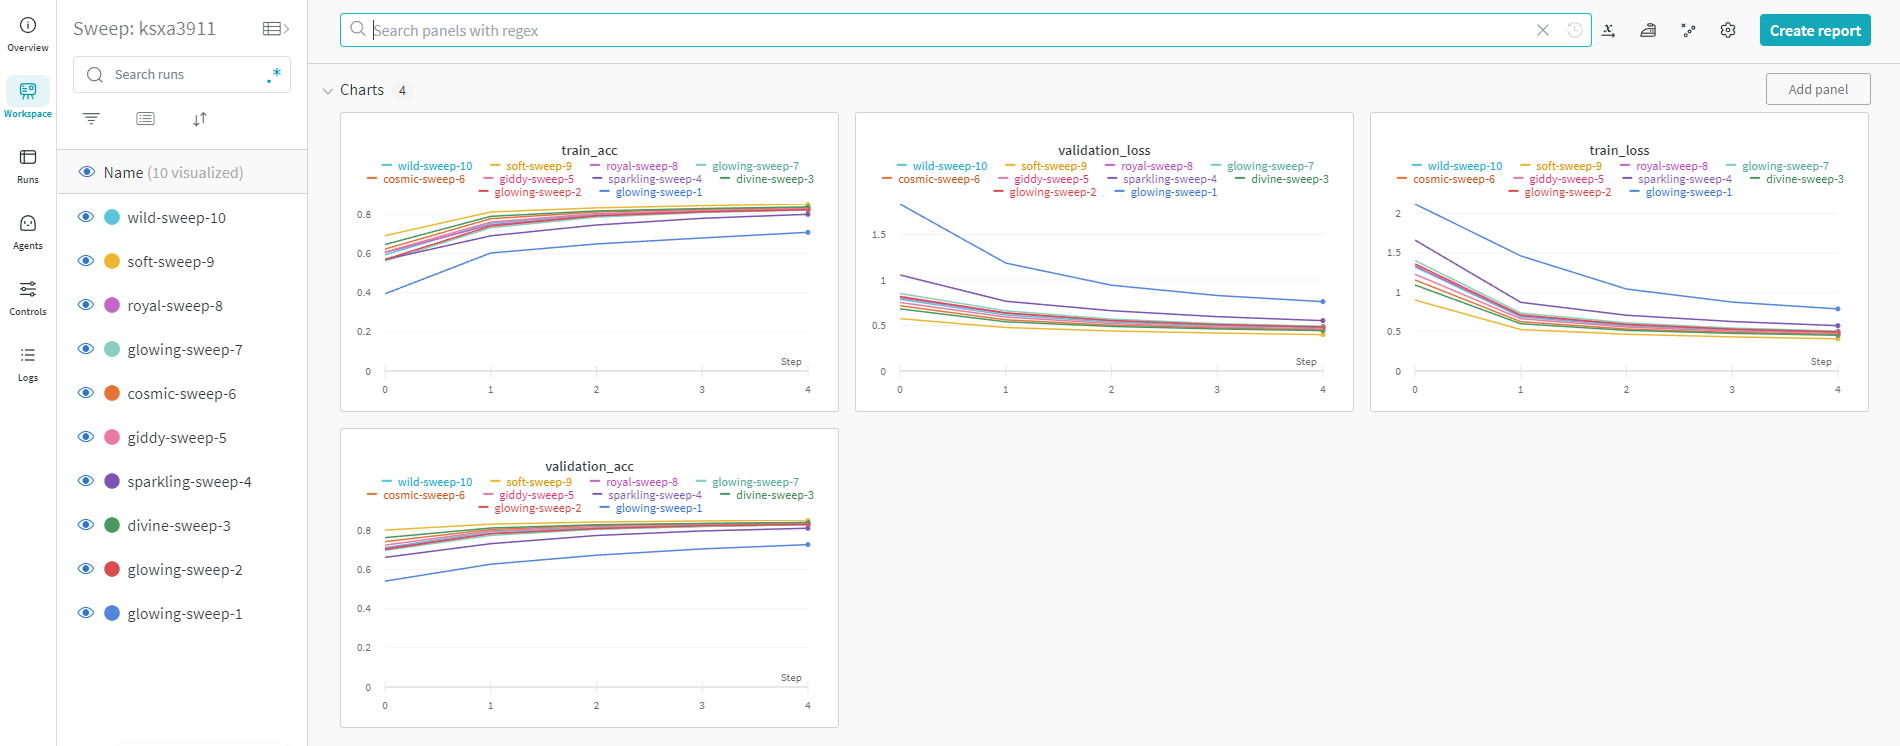

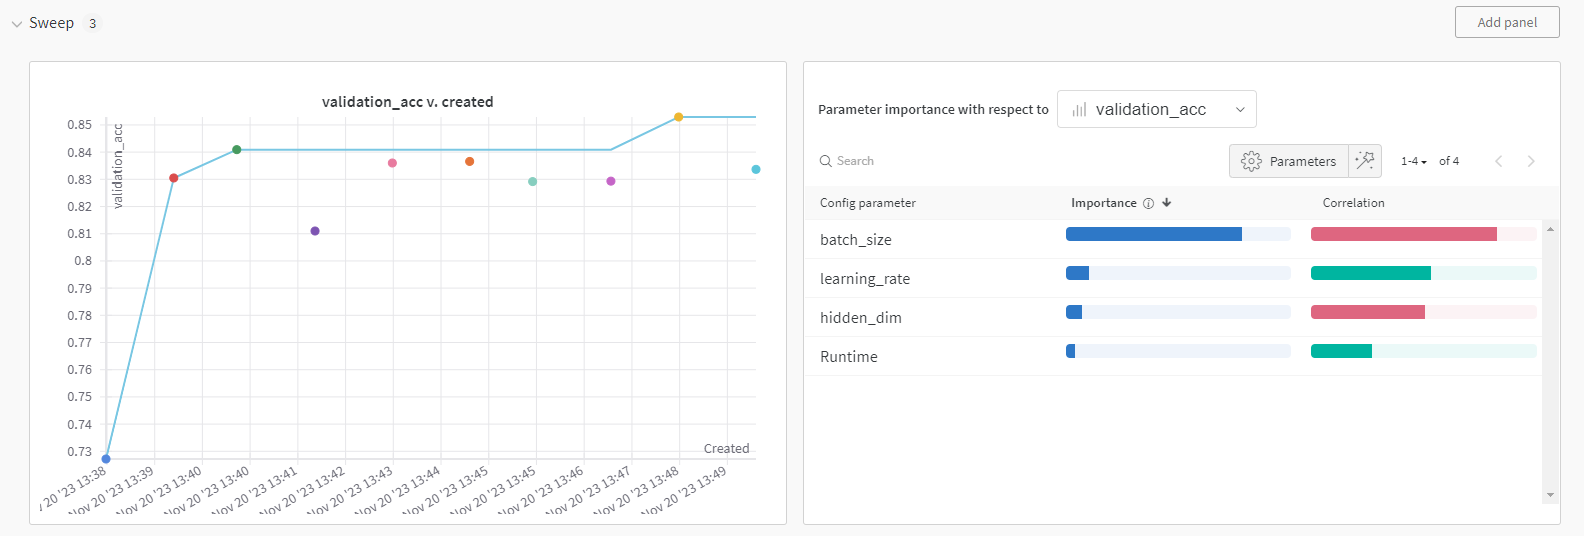

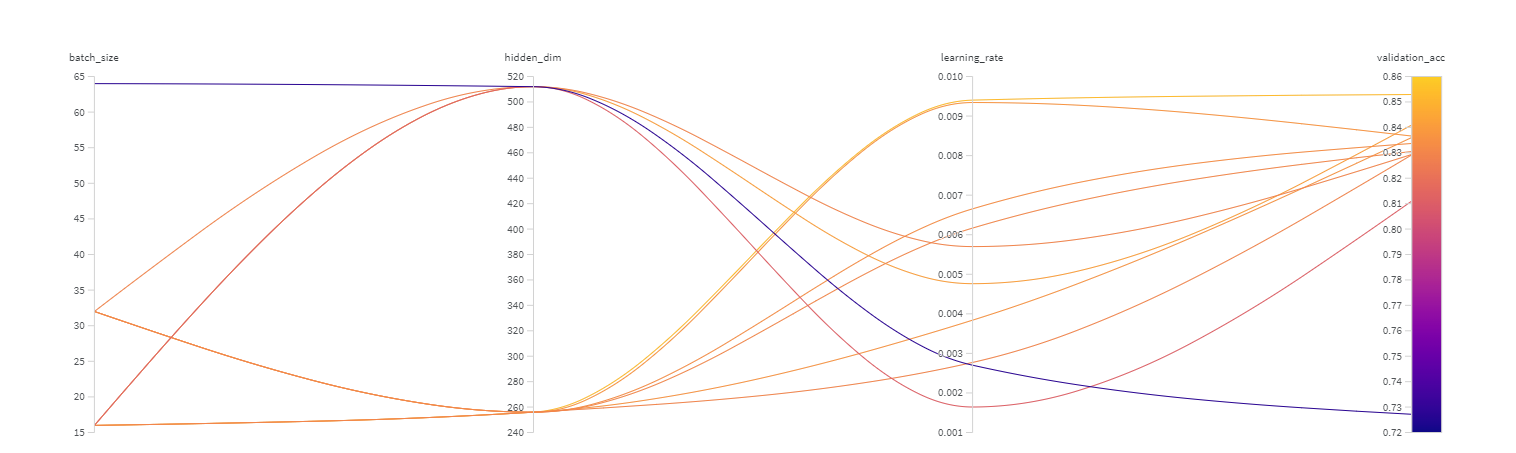